A/A testing of a mobile application. It is necessary to calculate the results of the A / A test by checking the FPR quality metric (we will check for conversions to a purchase). The split system is known to be broken. It is required to check the statement about the breakdown and find its causes if the split system is really broken

 

## Description of data
- experimentVariant - experiment variant
- version – application version
- purchase - fact of purchase


## Task
Run an A/A test
Calculate FPR at alpha level = 0.05 (set subsamples without replacement of 1000). You will see that FPR > alpha! We need the opposite - to be less.
Find the causes of the breakdown of the split system, focusing on the results of the experiment (hint: find an anomaly in the application version)
Write conclusions that can be drawn from the analysis of the results of the A / A test

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
hw = pd.read_csv('./hw_aa.csv', sep=';')

In [3]:
hw.head()

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0



**First run A/A test**

  0%|          | 0/1000 [00:00<?, ?it/s]

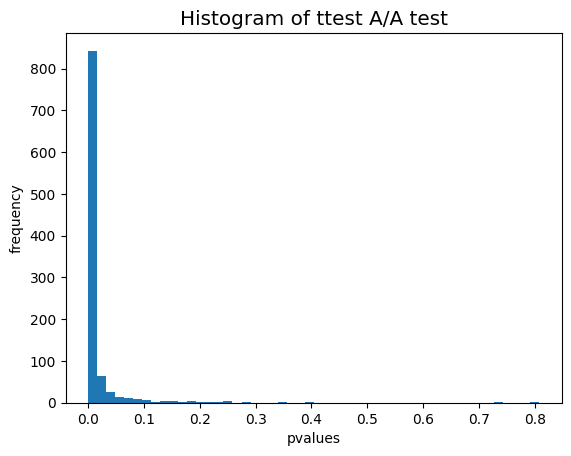

0.932

In [4]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Running A/A Test Simulations
for i in tqdm(range(simulations)):
    variant0 = hw[hw.experimentVariant == 0].purchase.sample(n_s, replace=False).values
    variant1 = hw[hw.experimentVariant == 1].purchase.sample(n_s, replace=False).values
    res.append(stats.ttest_ind(variant0, variant1, equal_var=False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A test")
plt.show()


# Check that the number of false positives does not exceed alpha
sum(np.array(res) <0.05) / simulations


**Note:**
The proportion of statistically significant differences is 0.943. In 94% of cases we get a stat. significant differences (p-value < 0.05) This is bad. After all, there shouldn't be much of a difference.

In [5]:
hw\
.groupby(['version', 'experimentVariant'])\
.agg({'uid':'nunique'})

uid
version  experimentVariant       
v2.8.0   0                  41283
         1                  41552
v2.9.0   0                  11921
         1                  12033
v3.7.4.0 0                   4204
         1                   4221
v3.8.0.0 0                   5694
         1                   6110

In [6]:
hw\
.groupby(['version', 'experimentVariant'])\
.agg({'purchase':'sum'})

purchase
version  experimentVariant          
v2.8.0   0                        41
         1                      1895
v2.9.0   0                       890
         1                       858
v3.7.4.0 0                       252
         1                       266
v3.8.0.0 0                       328
         1                       384

In [7]:
hw\
.groupby(['version', 'experimentVariant'])\
.agg({'purchase':'mean'})

purchase
version  experimentVariant          
v2.8.0   0                  0.000993
         1                  0.045606
v2.9.0   0                  0.074658
         1                  0.071304
v3.7.4.0 0                  0.059943
         1                  0.063018
v3.8.0.0 0                  0.057604
         1                  0.062848


And here is the problem. Something went wrong in version v.2.8.0. Averages over purchases should not be very different from each other in experimentVariant = 0 and experimentVariant = 1

Let's try to change the test a little

  0%|          | 0/1000 [00:00<?, ?it/s]

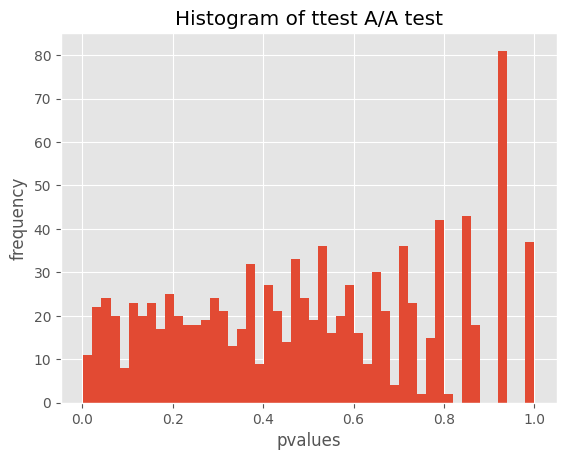

0.046

In [8]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Run A/A test simulations
for i in tqdm(range(simulations)):
    variant0 = hw[(hw.experimentVariant == 0) & 
                  (hw.version != 'v2.8.0')].purchase.sample(n_s, replace=False).values
    variant1 = hw[(hw.experimentVariant == 1) & 
                  (hw.version != 'v2.8.0')].purchase.sample(n_s, replace=False).values
    res.append(stats.ttest_ind(variant0, variant1, equal_var=False)[1]) # store the pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A test")
plt.show()


# Check that the number of false positives does not exceed alpha
sum(np.array(res) <0.05) / simulations


fpr approximately coincided with 5%. stat. proved that the differences were on version v2.8.0